<a href="https://colab.research.google.com/github/williambiondi/RecommenderGS/blob/main/recommenderGranSasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importazione dei dati e librerie


#Caricamento dati

In [1]:
!pip install tensorflow -q
!pip install transformers -q
!pip install tensorflow-recommenders -q
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from transformers import DistilBertTokenizer, TFDistilBertModel
from IPython import display
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import re
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.layers import Input, Concatenate, Embedding, Dense, Dropout, ReLU, Flatten
from tensorflow.keras.models import Model

In [3]:
items = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ArticoliGransasso.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/ClientiGransasso.csv')
purchases = pd.read_csv('https://raw.githubusercontent.com/williambiondi/RecommenderGS/main/OrdiniGransasso.csv')

In [4]:
items.drop(columns=['Unnamed: 0'], inplace=True)
customers.drop(columns=['Unnamed: 0'], inplace=True)
purchases.drop(columns=['Unnamed: 0'], inplace=True)

#Preparazione dati per modello


Annoto come interazione positiva (1) tutti gli articoli acquistati, come interazione negativa (-1) tutti gli articoli rimborsati

In [5]:
interactions = [1 if row['RefundedEUR'] == 0 else 0 for _,row in purchases.iterrows()]
purchases["Interaction"] = interactions

In [6]:
text_combined = []
for idx, row in items.iterrows():
  descriptive = row['ItemName'].lower()+" "+row['Description']
  text_combined.append(descriptive)
items['TextInfo'] = text_combined

In [7]:
len_desc = [len(row['TextInfo'].split(" ")) for _,row in items.iterrows()]
max(len_desc)

190

In [8]:
#items = items[items['Availability']==1].reset_index()

Utilizzo DistilBERT per ottenere gli embeddings di tutta l'informazione testuale degli articoli (nome articolo e descrizione) a parte anche gli embeddings delle categorie

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
enc_input = tokenizer(items['TextInfo'].tolist(),
                      padding=True,
                      truncation=True,
                      max_length=150,
                      return_tensors='tf')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [11]:
with tf.device('/CPU:0'):
  outputs = distilbert_model(enc_input)
  embeddings = outputs.last_hidden_state

In [12]:
embeddings_np = embeddings.numpy()
summary_embeddings = embeddings_np[:,0,:]
df_embeddings = pd.DataFrame(summary_embeddings)
df_embeddings.columns = [f'embedding_{i}' for i in range(df_embeddings.shape[1])]

In [13]:
items['Category_combined'] = items['Category'].apply(lambda x: ' '.join(x))
enc_input = tokenizer(items['Category_combined'].tolist(),
                      padding=True,
                      truncation=True,
                      max_length=20,
                      return_tensors='tf')
with tf.device('/CPU:0'):
  outputs = distilbert_model(enc_input)
  category_embeddings = outputs.last_hidden_state
category_embeddings_np = category_embeddings.numpy()
summary_category_embeddings = category_embeddings_np[:,0,:]
df_category_embeddings = pd.DataFrame(summary_category_embeddings)
df_category_embeddings.columns = [f'category_embedding_{i}' for i in range(df_category_embeddings.shape[1])]

In [14]:
df_category_embeddings.head()

,category_embedding_0,category_embedding_1,category_embedding_2,category_embedding_3,category_embedding_4,category_embedding_5,category_embedding_6,category_embedding_7,category_embedding_8,category_embedding_9,...,category_embedding_758,category_embedding_759,category_embedding_760,category_embedding_761,category_embedding_762,category_embedding_763,category_embedding_764,category_embedding_765,category_embedding_766,category_embedding_767
0,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,0.216081,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722
1,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,0.216081,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722
2,-0.003991,0.195033,0.163861,-0.568865,-0.057092,-0.201099,0.350111,0.403217,-0.281274,-0.351612,...,0.333690,-0.109416,-0.184354,0.027544,0.051049,-0.29962,0.105925,0.049944,0.232690,0.512860
3,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,0.216081,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722
4,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,0.216081,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722


In [15]:
df_embeddings.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,-0.152692,-0.702594,0.226576,-0.092627,0.150878,-0.052346,0.132293,0.289687,-0.130669,-0.294651,...,-0.045851,-0.592888,0.098133,-0.310700,0.045292,-0.331142,-0.110403,-0.167462,0.064619,-0.084191
1,-0.183465,-0.758047,0.025607,-0.106879,0.167659,-0.116864,0.084983,0.325271,0.031012,-0.256441,...,-0.039702,-0.501641,0.018874,-0.313824,0.023122,-0.488100,-0.089356,-0.199527,0.250173,-0.131353
2,-0.235759,-0.616278,0.186698,-0.050991,0.163522,-0.045681,0.081499,0.254824,-0.088808,-0.285371,...,0.009386,-0.555698,0.095906,-0.385060,-0.018019,-0.202692,-0.129432,-0.250053,0.047501,-0.117531
3,-0.080284,-0.587355,0.281824,-0.119877,0.063588,-0.044179,0.075656,0.288735,-0.159558,-0.265397,...,0.126247,-0.505958,0.169416,-0.327713,0.025113,-0.154299,-0.163061,-0.110773,0.150633,0.053784
4,-0.136119,-0.455886,0.220127,-0.032341,0.044970,-0.166100,0.079893,0.324760,-0.202329,-0.267275,...,-0.074009,-0.526029,0.137117,-0.344637,-0.017099,-0.273234,-0.202651,-0.110191,0.116088,0.078280


#Modello senza Item Description


In [ ]:
items['Composition'] = items['Composition'].astype(str)
gender_lookup = StringLookup()
collection_lookup = StringLookup()
composition_lookup = StringLookup()

gender_lookup.adapt(items['Gender'])
collection_lookup.adapt(items['Collection'])
composition_lookup.adapt(items['Composition'])

items['Gender_encoded'] = gender_lookup(items['Gender'])
items['Collection_encoded'] = collection_lookup(items['Collection'])
items['Composition_encoded'] = composition_lookup(items['Composition'])
df_category_embeddings['ItemId'] = items['ItemId']
full_items = items.merge(df_category_embeddings, on='ItemId')
df_full = full_items.merge(purchases, on='ItemId')

In [ ]:
feature_dict = {
    "item_id": df_full["ItemId"].values,
    "collection": df_full["Collection_encoded"].values,
    "gender": df_full["Gender_encoded"].values,
    "composition": df_full["Composition_encoded"].values,
    "category_embedding" : df_full[[f'category_embedding_{i}' for i in range(df_category_embeddings.shape[1]-1)]].values,
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "interaction" : df_full['Interaction'].values.reshape(-1,1)
}


In [ ]:
data_tf = tf.data.Dataset.from_tensor_slices(feature_dict)

candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "category_embedding" : full_items[[f'category_embedding_{i}' for i in range(df_category_embeddings.shape[1]-1)]].values,
    "collection": full_items["Collection_encoded"].values,
    "gender": full_items["Gender_encoded"].values,
    "composition": full_items["Composition_encoded"].values
})
candidates_ds = candidates_tf.batch(32)

In [ ]:
data_tf = data_tf.shuffle(buffer_size=1024, seed=999, reshuffle_each_iteration=True)

full_size = len(data_tf)
train_size = int(full_size * 0.7)
val_size = int(full_size * 0.15)
test_size = full_size - train_size - val_size

train = data_tf.take(train_size)
val = data_tf.skip(train_size).take(val_size)
test = data_tf.skip(train_size + val_size)

In [ ]:
batch_size = 32
train = train.shuffle(buffer_size=1024, seed = 999).batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

In [ ]:
class NoDescRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, features, training = False):
    user_emb = self.user_model({"user_id": features['user_id']
                                })
    item_emb = self.item_model({"category_embedding":features['category_embedding'],
                                "gender":features['gender'],
                                "collection":features['collection'],
                                "composition": features["composition"],
                                })
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task( labels = features['interaction'], predictions = predictions)
    return retrieval_loss + ranking_loss

In [ ]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_category_embeddings.shape[1] - 1

In [ ]:
category_embedding_input = Input(shape=(df_category_embeddings.shape[1]-1,), name='category_embedding')
gender_input = Input(shape=(1,), name='gender')
collection_input = Input(shape=(1,), name='collection')
composition_input = Input(shape=(1,), name='composition')

item_inputs =[category_embedding_input, gender_input, collection_input, composition_input]
concatenated = Concatenate()(item_inputs)

x = Dense(18, activation='relu')(concatenated)
x = Dropout(0.25)(x)
x = Dense(12, activation='relu')(x)
x = Dropout(0.25)(x)

item_model = Model(inputs=item_inputs, outputs=x)

In [ ]:
user_id_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
user_embedding = Embedding(input_dim=len(unique_user_ids), output_dim=embedding_dim, name="user_embedding")(user_id_input)

combined_input = Concatenate()([user_embedding])

x = Dense(18, activation="relu")(combined_input)
x = Dropout(0.25)(x)
x = Dense(12, activation="relu")(x)
x = Dropout(0.25)(x)
x = Flatten()(x)

user_model = Model(inputs=[user_id_input], outputs=x)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              mode='min',
                                              start_from_epoch = 20,
                                              restore_best_weights=True)

In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [ ]:
recommender = NoDescRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


435/435 [==============================] - 72s 162ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0317 - factorized_top_k/top_5_categorical_accuracy: 0.0321 - factorized_top_k/top_10_categorical_accuracy: 0.0329 - factorized_top_k/top_50_categorical_accuracy: 0.0404 - factorized_top_k/top_100_categorical_accuracy: 0.0570 - binary_accuracy: 0.7950 - loss: 110.8013 - regularization_loss: 0.0000e+00 - total_loss: 110.8013 - val_factorized_top_k/top_1_categorical_accuracy: 0.0289 - val_factorized_top_k/top_5_categorical_accuracy: 0.0289 - val_factorized_top_k/top_10_categorical_accuracy: 0.0319 - val_factorized_top_k/top_50_categorical_accuracy: 0.0446 - val_factorized_top_k/top_100_categorical_accuracy: 0.0681 - val_binary_accuracy: 0.8084 - val_loss: 5.9997 - val_regularization_loss: 0.0000e+00 - val_total_loss: 5.9997
Epoch 2/100
435/435 [==============================] - 70s 160ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0383 - factorized_top_k/top_5_categorical_a

#Modello con Item description

In [16]:
items['Composition'] = items['Composition'].astype(str)
gender_lookup = StringLookup()
collection_lookup = StringLookup()
composition_lookup = StringLookup()

gender_lookup.adapt(items['Gender'])
collection_lookup.adapt(items['Collection'])
composition_lookup.adapt(items['Composition'])

items['Gender_encoded'] = gender_lookup(items['Gender'])
items['Collection_encoded'] = collection_lookup(items['Collection'])
items['Composition_encoded'] = composition_lookup(items['Composition'])

In [17]:
df_embeddings['ItemId'] = items['ItemId']
df_category_embeddings['ItemId'] = items['ItemId']
full_items = items.merge(df_embeddings, on='ItemId')
full_items = full_items.merge(df_category_embeddings, on='ItemId')
df_full = full_items.merge(purchases, on='ItemId')

In [18]:
df_embeddings.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,ItemId
0,-0.152692,-0.702594,0.226576,-0.092627,0.150878,-0.052346,0.132293,0.289687,-0.130669,-0.294651,...,-0.592888,0.098133,-0.310700,0.045292,-0.331142,-0.110403,-0.167462,0.064619,-0.084191,0
1,-0.183465,-0.758047,0.025607,-0.106879,0.167659,-0.116864,0.084983,0.325271,0.031012,-0.256441,...,-0.501641,0.018874,-0.313824,0.023122,-0.488100,-0.089356,-0.199527,0.250173,-0.131353,1
2,-0.235759,-0.616278,0.186698,-0.050991,0.163522,-0.045681,0.081499,0.254824,-0.088808,-0.285371,...,-0.555698,0.095906,-0.385060,-0.018019,-0.202692,-0.129432,-0.250053,0.047501,-0.117531,2
3,-0.080284,-0.587355,0.281824,-0.119877,0.063588,-0.044179,0.075656,0.288735,-0.159558,-0.265397,...,-0.505958,0.169416,-0.327713,0.025113,-0.154299,-0.163061,-0.110773,0.150633,0.053784,3
4,-0.136119,-0.455886,0.220127,-0.032341,0.044970,-0.166100,0.079893,0.324760,-0.202329,-0.267275,...,-0.526029,0.137117,-0.344637,-0.017099,-0.273234,-0.202651,-0.110191,0.116088,0.078280,4


In [19]:
df_category_embeddings.head()

,category_embedding_0,category_embedding_1,category_embedding_2,category_embedding_3,category_embedding_4,category_embedding_5,category_embedding_6,category_embedding_7,category_embedding_8,category_embedding_9,...,category_embedding_759,category_embedding_760,category_embedding_761,category_embedding_762,category_embedding_763,category_embedding_764,category_embedding_765,category_embedding_766,category_embedding_767,ItemId
0,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722,0
1,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722,1
2,-0.003991,0.195033,0.163861,-0.568865,-0.057092,-0.201099,0.350111,0.403217,-0.281274,-0.351612,...,-0.109416,-0.184354,0.027544,0.051049,-0.29962,0.105925,0.049944,0.232690,0.512860,2
3,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722,3
4,-0.057772,0.183025,0.119610,-0.696748,-0.141949,-0.084501,0.430838,0.352050,-0.317388,-0.270157,...,-0.222772,0.007465,0.088298,0.123053,-0.18269,-0.047629,-0.085874,0.207535,0.519722,4


In [20]:
feature_dict = {
    "item_id": df_full["ItemId"].values,
    "collection": df_full["Collection_encoded"].values,
    "gender": df_full["Gender_encoded"].values,
    "composition": df_full["Composition_encoded"].values,
    "item_embedding" : df_full[[f'embedding_{i}' for i in range(df_embeddings.shape[1]-1)]].values,
    "category_embedding" : df_full[[f'category_embedding_{i}' for i in range(df_category_embeddings.shape[1]-1)]].values,
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "interaction" : df_full['Interaction'].values.reshape(-1,1)
}


In [21]:
data_tf = tf.data.Dataset.from_tensor_slices(feature_dict)

candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'embedding_{i}' for i in range(df_embeddings.shape[1]-1)]].values,
    "category_embedding" : full_items[[f'category_embedding_{i}' for i in range(df_category_embeddings.shape[1]-1)]].values,
    "collection": full_items["Collection_encoded"].values,
    "gender": full_items["Gender_encoded"].values,
    "composition": full_items["Composition_encoded"].values
})
candidates_ds = candidates_tf.batch(32)

In [22]:
data_tf = data_tf.shuffle(buffer_size=1024, seed=999, reshuffle_each_iteration=True)

full_size = len(data_tf)
train_size = int(full_size * 0.7)
val_size = int(full_size * 0.15)
test_size = full_size - train_size - val_size

train = data_tf.take(train_size)
val = data_tf.skip(train_size).take(val_size)
test = data_tf.skip(train_size + val_size)

In [23]:
batch_size = 32
train = train.shuffle(buffer_size=1024, seed = 999).batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

In [24]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, features, training = False):
    user_emb = self.user_model({"user_id": features['user_id']
                                })
    item_emb = self.item_model({"item_embedding":features['item_embedding'],
                                "category_embedding":features['category_embedding'],
                                "gender":features['gender'],
                                "collection":features['collection'],
                                "composition": features["composition"],
                                })
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task( labels = features['interaction'], predictions = predictions)
    return retrieval_loss + ranking_loss

In [25]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_embeddings.shape[1] + df_category_embeddings.shape[1] - 2

In [38]:
item_embedding_input = Input(shape=(df_embeddings.shape[1]-1,), name='item_embedding')
category_embedding_input = Input(shape=(df_category_embeddings.shape[1]-1,), name='category_embedding')
gender_input = Input(shape=(1,), name='gender')
collection_input = Input(shape=(1,), name='collection')
composition_input = Input(shape=(1,), name='composition')

item_inputs =[item_embedding_input, category_embedding_input, gender_input, collection_input, composition_input]
concatenated = Concatenate()(item_inputs)

x = Dense(256, activation='relu')(concatenated)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

item_model = Model(inputs=item_inputs, outputs=x)

In [41]:
user_id_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
user_embedding = Embedding(input_dim=len(unique_user_ids), output_dim=embedding_dim, name="user_embedding")(user_id_input)

combined_input = Concatenate()([user_embedding])

x = Dense(256, activation="relu")(combined_input)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

user_model = Model(inputs=[user_id_input], outputs=x)

In [33]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_factorized_top_k/top_5_categorical_accuracy',
                                              patience=10,
                                              mode='max',
                                              start_from_epoch = 20,
                                              restore_best_weights=True)

In [43]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [44]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100
435/435 [==============================] - 108s 240ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0324 - factorized_top_k/top_5_categorical_accuracy: 0.0400 - factorized_top_k/top_10_categorical_accuracy: 0.0464 - factorized_top_k/top_50_categorical_accuracy: 0.0715 - factorized_top_k/top_100_categorical_accuracy: 0.0984 - binary_accuracy: 0.7826 - loss: 110.1088 - regularization_loss: 0.0000e+00 - total_loss: 110.1088 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0030 - val_factorized_top_k/top_10_categorical_accuracy: 0.0047 - val_factorized_top_k/top_50_categorical_accuracy: 0.0258 - val_factorized_top_k/top_100_categorical_accuracy: 0.0547 - val_binary_accuracy: 0.7292 - val_loss: 5.6995 - val_regularization_loss: 0.0000e+00 - val_total_loss: 5.6995
Epoch 2/100
435/435 [==============================] - 104s 240ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0154 - factorized_top_k/t

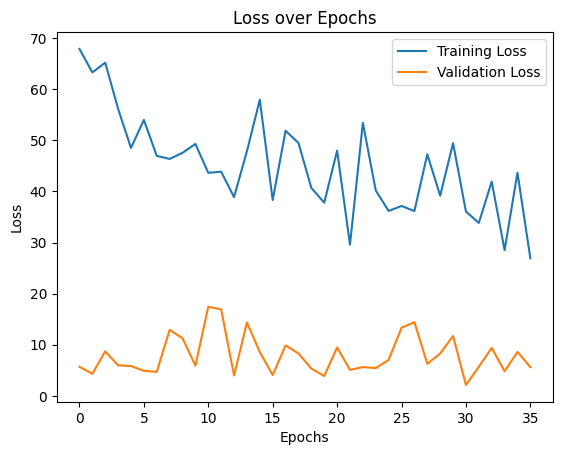

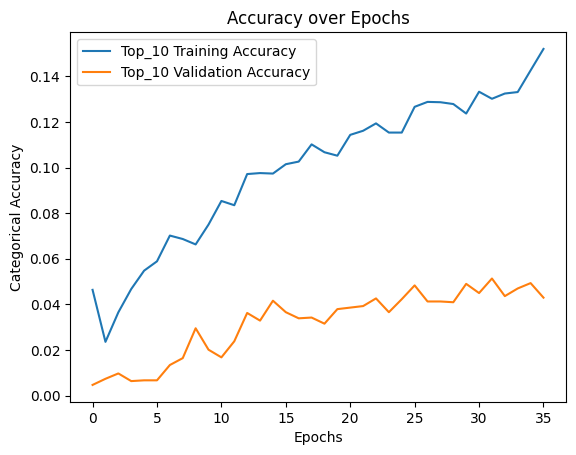

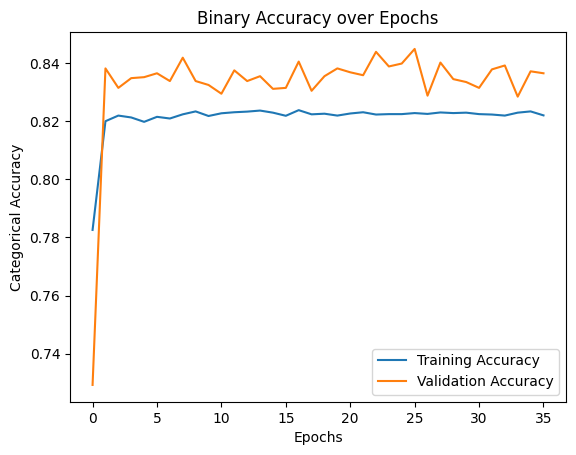

In [45]:
metrics = history.history
# Plot loss
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot categorical accuracy
plt.plot(metrics['factorized_top_k/top_10_categorical_accuracy'], label='Top_10 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_10_categorical_accuracy'], label='Top_10 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

# Plot binary accuracy
plt.plot(metrics['binary_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

In [46]:
recommender.evaluate(test)

94/94 [==============================] - 18s 195ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0040 - factorized_top_k/top_5_categorical_accuracy: 0.0080 - factorized_top_k/top_10_categorical_accuracy: 0.0121 - factorized_top_k/top_50_categorical_accuracy: 0.0446 - factorized_top_k/top_100_categorical_accuracy: 0.0677 - binary_accuracy: 0.8189 - loss: 156.3769 - regularization_loss: 0.0000e+00 - total_loss: 156.3769


[0.0040241447277367115,
 0.008048289455473423,
 0.012072434648871422,
 0.04460093751549721,
 0.06773976981639862,
 0.818913459777832,
 15.351922035217285,
 0,
 15.351922035217285]

#PCA

Riduco gli embeddings

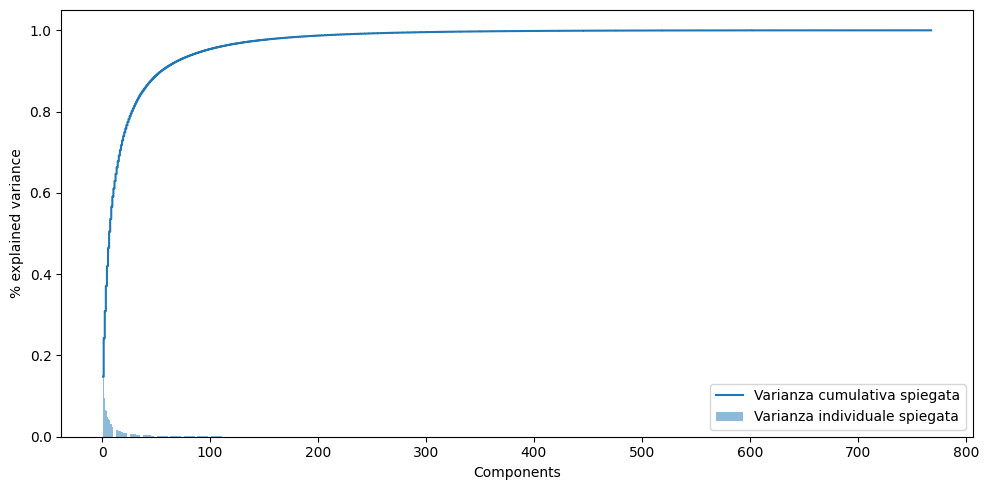

In [ ]:
pca = PCA()
pca.fit(df_embeddings)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

n_components = np.where(cumulative>=0.95)[0][0]+1

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained) + 1), explained, alpha=0.5, align='center', label='Varianza individuale spiegata')
plt.step(range(1, len(cumulative) + 1), cumulative, where='mid', label='Varianza cumulativa spiegata')
plt.ylabel('% explained variance')
plt.xlabel('Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(df_embeddings)
df_reduced_desc = pd.DataFrame(reduced, columns = [f"pc_desc{i}" for i in range(reduced.shape[1])])

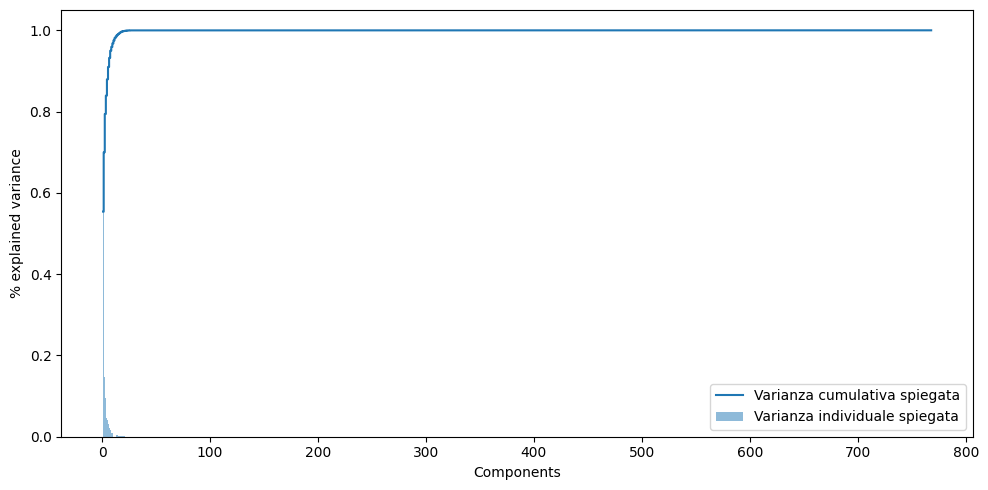

In [ ]:
pca = PCA()
pca.fit(df_category_embeddings)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

n_components = np.where(cumulative>=0.95)[0][0]+1

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained) + 1), explained, alpha=0.5, align='center', label='Varianza individuale spiegata')
plt.step(range(1, len(cumulative) + 1), cumulative, where='mid', label='Varianza cumulativa spiegata')
plt.ylabel('% explained variance')
plt.xlabel('Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(df_category_embeddings)
df_reduced_cat = pd.DataFrame(reduced, columns = [f"pc_cat{i}" for i in range(reduced.shape[1])])

In [ ]:
df_reduced_cat['ItemId'] = items['ItemId']

In [ ]:
df_reduced_desc['ItemId'] = items['ItemId']

In [ ]:
df_reduced_cat.shape

(3497, 10)

In [ ]:
df_reduced_desc.shape

(3497, 96)

#Training PCA senza descrizioni

In [ ]:
items['Composition'] = items['Composition'].astype(str)
gender_lookup = StringLookup()
collection_lookup = StringLookup()
composition_lookup = StringLookup()

gender_lookup.adapt(items['Gender'])
collection_lookup.adapt(items['Collection'])
composition_lookup.adapt(items['Composition'])

items['Gender_encoded'] = gender_lookup(items['Gender'])
items['Collection_encoded'] = collection_lookup(items['Collection'])
items['Composition_encoded'] = composition_lookup(items['Composition'])

In [ ]:
full_items = items.merge(df_reduced_desc, on='ItemId')
full_items = full_items.merge(df_reduced_cat, on='ItemId')
df_full = full_items.merge(purchases, on='ItemId')

In [ ]:
feature_dict = {
    "item_id": df_full["ItemId"].values,
    "collection": df_full["Collection_encoded"].values,
    "gender": df_full["Gender_encoded"].values,
    "composition": df_full["Composition_encoded"].values,
    "category_embedding" : df_full[[f'pc_cat{i}' for i in range(df_reduced_cat.shape[1]-1)]].values,
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "interaction" : df_full['Interaction'].values.reshape(-1,1)
}


In [ ]:
data_tf = tf.data.Dataset.from_tensor_slices(feature_dict)

candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "category_embedding" : full_items[[f'pc_cat{i}' for i in range(df_reduced_cat.shape[1]-1)]].values,
    "collection": full_items["Collection_encoded"].values,
    "gender": full_items["Gender_encoded"].values,
    "composition": full_items["Composition_encoded"].values
})
candidates_ds = candidates_tf.batch(32)

In [ ]:
data_tf = data_tf.shuffle(buffer_size=1024, seed=999, reshuffle_each_iteration=True)

full_size = len(data_tf)
train_size = int(full_size * 0.7)
val_size = int(full_size * 0.15)
test_size = full_size - train_size - val_size

train = data_tf.take(train_size)
val = data_tf.skip(train_size).take(val_size)
test = data_tf.skip(train_size + val_size)

In [ ]:
batch_size = 32
train = train.shuffle(buffer_size=1024, seed = 999).batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

In [ ]:
class NoDescRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, features, training = False):
    user_emb = self.user_model({"user_id": features['user_id']
                                })
    item_emb = self.item_model({"category_embedding":features['category_embedding'],
                                "gender":features['gender'],
                                "collection":features['collection'],
                                "composition": features["composition"],
                                })
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task( labels = features['interaction'], predictions = predictions)
    return retrieval_loss + ranking_loss

In [ ]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_reduced_cat.shape[1]-1

In [ ]:
category_embedding_input = Input(shape=(df_reduced_cat.shape[1]-1,), name='category_embedding')
gender_input = Input(shape=(1,), name='gender')
collection_input = Input(shape=(1,), name='collection')
composition_input = Input(shape=(1,), name='composition')

item_inputs =[category_embedding_input, gender_input, collection_input, composition_input]
concatenated = Concatenate()(item_inputs)

x = Dense(25, activation='relu')(concatenated)
x = Dropout(0.18)(x)
x = Dense(12, activation='relu')(x)
x = Dropout(0.18)(x)

item_model = Model(inputs=item_inputs, outputs=x)

In [ ]:
user_id_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
user_embedding = Embedding(input_dim=len(unique_user_ids), output_dim=embedding_dim, name="user_embedding")(user_id_input)

combined_input = Concatenate()([user_embedding])

x = Dense(25, activation="relu")(combined_input)
x = Dropout(0.18)(x)
x = Dense(12, activation="relu")(x)
x = Dropout(0.15)(x)
x = Flatten()(x)

user_model = Model(inputs=[user_id_input], outputs=x)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              mode='min',
                                              start_from_epoch = 25,
                                              restore_best_weights=True)

In [ ]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
recommender = NoDescRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100
435/435 [==============================] - 67s 148ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0055 - factorized_top_k/top_5_categorical_accuracy: 0.0083 - factorized_top_k/top_10_categorical_accuracy: 0.0093 - factorized_top_k/top_50_categorical_accuracy: 0.0243 - factorized_top_k/top_100_categorical_accuracy: 0.0376 - binary_accuracy: 0.6974 - loss: 109.3920 - regularization_loss: 0.0000e+00 - total_loss: 109.3920 - val_factorized_top_k/top_1_categorical_accuracy: 0.0138 - val_factorized_top_k/top_5_categorical_accuracy: 0.0242 - val_factorized_top_k/top_10_categorical_accuracy: 0.0289 - val_factorized_top_k/top_50_categorical_accuracy: 0.0547 - val_factorized_top_k/top_100_categorical_accuracy: 0.0715 - val_binary_accuracy: 0.5664 - val_loss: 6.5382 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6.5382
Epoch 2/100
435/435 [==============================] - 66s 152ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0293 - factorized_top_k/top_5_c

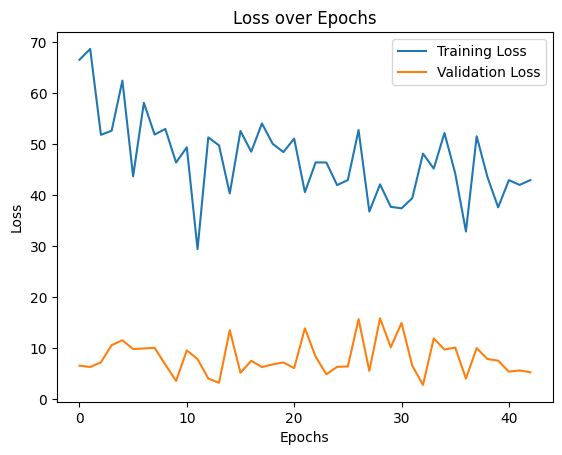

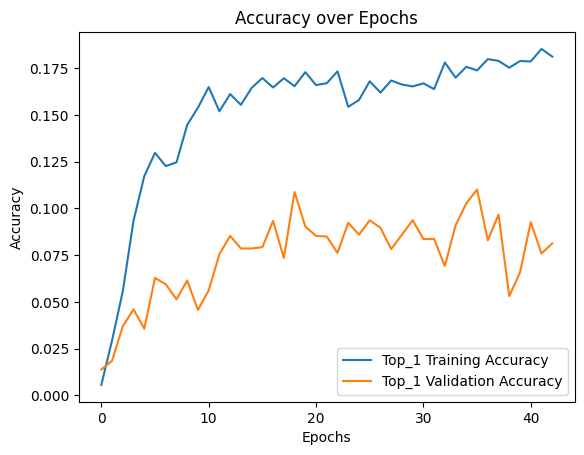

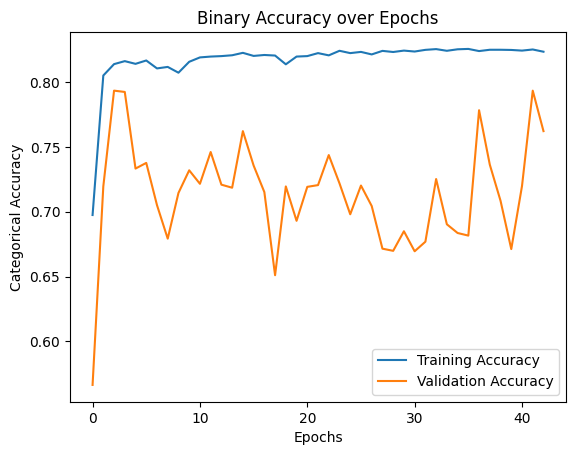

In [ ]:
metrics = history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot top 1 cat accuracy

plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot binary accuracy
plt.plot(metrics['binary_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

In [ ]:
recommender.evaluate(test)

94/94 [==============================] - 11s 118ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0154 - factorized_top_k/top_5_categorical_accuracy: 0.0282 - factorized_top_k/top_10_categorical_accuracy: 0.0315 - factorized_top_k/top_50_categorical_accuracy: 0.0634 - factorized_top_k/top_100_categorical_accuracy: 0.0885 - binary_accuracy: 0.6449 - loss: 141.4731 - regularization_loss: 0.0000e+00 - total_loss: 141.4731


[0.015425888821482658,
 0.028169013559818268,
 0.031522467732429504,
 0.06338027864694595,
 0.08853118866682053,
 0.6448692083358765,
 12.139924049377441,
 0,
 12.139924049377441]

#Training PCA con Descrizioni

In [ ]:
items['Composition'] = items['Composition'].astype(str)
gender_lookup = StringLookup()
collection_lookup = StringLookup()
composition_lookup = StringLookup()

gender_lookup.adapt(items['Gender'])
collection_lookup.adapt(items['Collection'])
composition_lookup.adapt(items['Composition'])

items['Gender_encoded'] = gender_lookup(items['Gender'])
items['Collection_encoded'] = collection_lookup(items['Collection'])
items['Composition_encoded'] = composition_lookup(items['Composition'])

In [ ]:
feature_dict = {
    "item_id": df_full["ItemId"].values,
    "collection": df_full["Collection_encoded"].values,
    "gender": df_full["Gender_encoded"].values,
    "composition": df_full["Composition_encoded"].values,
    "item_embedding" : df_full[[f'pc_desc{i}' for i in range(df_reduced_desc.shape[1]-1)]].values,
    "category_embedding" : df_full[[f'pc_cat{i}' for i in range(df_reduced_cat.shape[1]-1)]].values,
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "interaction" : df_full['Interaction'].values.reshape(-1,1)
}


In [ ]:
data_tf = tf.data.Dataset.from_tensor_slices(feature_dict)

candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'pc_desc{i}' for i in range(df_reduced_desc.shape[1]-1)]].values,
    "category_embedding" : full_items[[f'pc_cat{i}' for i in range(df_reduced_cat.shape[1]-1)]].values,
    "collection": full_items["Collection_encoded"].values,
    "gender": full_items["Gender_encoded"].values,
    "composition": full_items["Composition_encoded"].values
})
candidates_ds = candidates_tf.batch(32)

In [ ]:
data_tf = data_tf.shuffle(buffer_size=1024, seed=999, reshuffle_each_iteration=True)

full_size = len(data_tf)
train_size = int(full_size * 0.7)
val_size = int(full_size * 0.15)
test_size = full_size - train_size - val_size

train = data_tf.take(train_size)
val = data_tf.skip(train_size).take(val_size)
test = data_tf.skip(train_size + val_size)

In [ ]:
batch_size = 32
train = train.shuffle(buffer_size=1024, seed = 999).batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

In [ ]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.retrieval_task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))
    self.rank_task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

  def compute_loss(self, features, training = False):
    user_emb = self.user_model({"user_id": features['user_id']
                                })
    item_emb = self.item_model({"item_embedding":features['item_embedding'],
                                "category_embedding":features['category_embedding'],
                                "gender":features['gender'],
                                "collection":features['collection'],
                                "composition": features["composition"],
                                })
    retrieval_loss = self.retrieval_task(user_emb, item_emb)
    predictions = tf.reduce_sum(user_emb * item_emb, axis=1)
    ranking_loss = self.rank_task( labels = features['interaction'], predictions = predictions)
    return retrieval_loss + ranking_loss

In [ ]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = df_reduced_desc.shape[1] + df_reduced_cat.shape[1] - 2

In [ ]:
item_embedding_input = Input(shape=(df_reduced_desc.shape[1]-1,), name='item_embedding')
category_embedding_input = Input(shape=(df_reduced_cat.shape[1]-1,), name='category_embedding')
gender_input = Input(shape=(1,), name='gender')
collection_input = Input(shape=(1,), name='collection')
composition_input = Input(shape=(1,), name='composition')

item_inputs =[item_embedding_input, category_embedding_input, gender_input, collection_input, composition_input]
concatenated = Concatenate()(item_inputs)

x = Dense(18, activation='relu')(concatenated)
x = Dropout(0.25)(x)
x = Dense(12, activation='relu')(x)
x = Dropout(0.25)(x)

item_model = Model(inputs=item_inputs, outputs=x)

In [ ]:
user_id_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
user_embedding = Embedding(input_dim=len(unique_user_ids), output_dim=embedding_dim, name="user_embedding")(user_id_input)

combined_input = Concatenate()([user_embedding])

x = Dense(18, activation="relu")(combined_input)
x = Dropout(0.25)(x)
x = Dense(12, activation="relu")(x)
x = Dropout(0.25)(x)
x = Flatten()(x)

user_model = Model(inputs=[user_id_input], outputs=x)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              mode='min',
                                              start_from_epoch = 20,
                                              restore_best_weights=True)

In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.999,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [ ]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)
history = recommender.fit(train,
                validation_data = val,
                epochs=100, callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


435/435 [==============================] - 69s 155ms/step - factorized_top_k/top_1_categorical_accuracy: 5.0324e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0012 - factorized_top_k/top_10_categorical_accuracy: 0.0014 - factorized_top_k/top_50_categorical_accuracy: 0.0170 - factorized_top_k/top_100_categorical_accuracy: 0.0380 - binary_accuracy: 0.6710 - loss: 109.9171 - regularization_loss: 0.0000e+00 - total_loss: 109.9171 - val_factorized_top_k/top_1_categorical_accuracy: 0.0027 - val_factorized_top_k/top_5_categorical_accuracy: 0.0040 - val_factorized_top_k/top_10_categorical_accuracy: 0.0074 - val_factorized_top_k/top_50_categorical_accuracy: 0.0329 - val_factorized_top_k/top_100_categorical_accuracy: 0.0755 - val_binary_accuracy: 0.7691 - val_loss: 6.6014 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6.6014
Epoch 2/100
435/435 [==============================] - 63s 145ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0035 - factorized_top_k/top_5_categoric

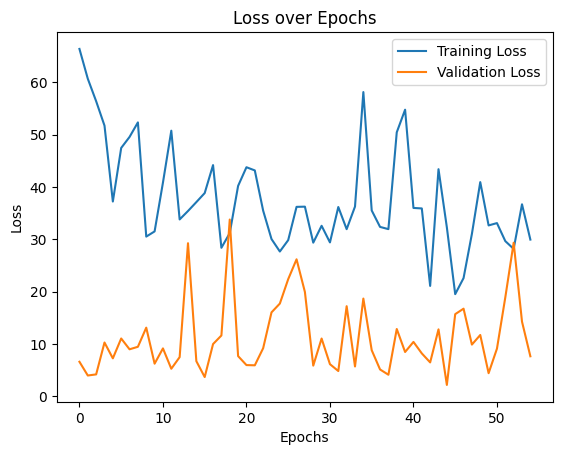

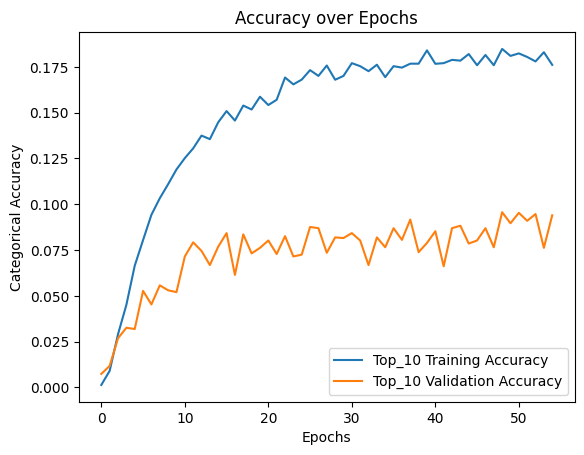

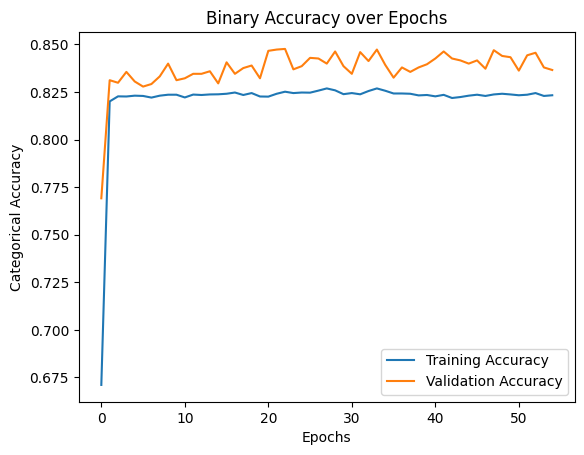

In [ ]:
metrics = history.history
# Plot loss
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot categorical accuracy
plt.plot(metrics['factorized_top_k/top_10_categorical_accuracy'], label='Top_10 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_10_categorical_accuracy'], label='Top_10 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

# Plot binary accuracy
plt.plot(metrics['binary_accuracy'], label='Training Accuracy')
plt.plot(metrics['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Binary Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

#Tuning dei parametri

In [ ]:
class HyperRecommender(HyperModel):
  def __init__(self, user_input_dim, item_input_dim, embedding_dim, candidates_ds):
    self.user_input_dim = user_input_dim
    self.item_input_dim = item_input_dim
    self.embedding_dim = embedding_dim
    self.candidates_ds = candidates_ds

  def build(self, hp):
    unique_user_ids = df_full['UserId'].unique().astype(str)
    unique_item_ids = df_full['ItemId'].unique().astype(str)
    embedding_dim = df_embeddings.shape[1]-1
    user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dropout(hp.Float("dropout_rate", min_value = 0.05, max_value = 0.4, step = 0.05)),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.Dropout(hp.Float("dropout_rate", min_value = 0.05, max_value = 0.4, step = 0.05)),
                                  tf.keras.layers.Flatten(),
                                  ])
    item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2)),
                                  tf.keras.layers.ReLU(),
                                  tf.keras.layers.Dropout(hp.Float("dropout_rate", min_value = 0.05, max_value = 0.4, step = 0.05)),
                                  tf.keras.layers.Dense(hp.Int("dense_size", min_value=2, max_value=32, step=2))
                                ])

    # Define the CFRecommender model
    model = CFRecommender(user_model, item_model, self.candidates_ds)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=6e-2, sampling='LOG')),
    )

    return model

In [ ]:
hypermodel = HyperRecommender(user_input_dim = len(unique_user_ids),
                              item_input_dim = embedding_dim,
                              embedding_dim = embedding_dim,
                              candidates_ds = candidates_ds)


In [ ]:
tuner = RandomSearch(hypermodel,
                     objective = 'val_loss',
                     max_trials = 50,
                     directory = 'keras_tuner_dir',
                     project_name = 'gs_recommender')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
tuner.search_space_summary()
tuner.search(train, validation_data=val, epochs=20)
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
for hparam in best_hyperparams.values:
  print(f'{hparam}: {best_hyperparams.get(hparam)}')

Trial 49 Complete [00h 19m 40s]
val_loss: 26.628984451293945

Best val_loss So Far: 22.390087127685547
Total elapsed time: 15h 36m 14s

Search: Running Trial #50

Value             |Best Value So Far |Hyperparameter
32                |32                |dense_size
0.4               |0.05              |dropout_rate
0.00036674        |0.0041061         |learning_rate

Epoch 1/20
398/398 [==============================] - 61s 149ms/step - factorized_top_k/top_1_categorical_accuracy: 3.1451e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0010 - factorized_top_k/top_10_categorical_accuracy: 0.0021 - factorized_top_k/top_50_categorical_accuracy: 0.0170 - factorized_top_k/top_100_categorical_accuracy: 0.0359 - binary_accuracy: 0.7246 - loss: 111.0723 - regularization_loss: 0.0000e+00 - total_loss: 111.0723 - val_factorized_top_k/top_1_categorical_accuracy: 0.0038 - val_factorized_top_k/top_5_categorical_accuracy: 0.0069 - val_factorized_top_k/top_10_categorical_accuracy: 0.0091 - val_fac

In [ ]:
best_model = tuner.hypermodel.build(best_hyperparams)
best_history = best_model.fit(train, validation_data=val, epochs=100)

Epoch 1/100
398/398 [==============================] - 62s 152ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0149 - factorized_top_k/top_5_categorical_accuracy: 0.0196 - factorized_top_k/top_10_categorical_accuracy: 0.0243 - factorized_top_k/top_50_categorical_accuracy: 0.0572 - factorized_top_k/top_100_categorical_accuracy: 0.0933 - binary_accuracy: 0.7798 - loss: 109.5902 - regularization_loss: 0.0000e+00 - total_loss: 109.5902 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 3.1456e-04 - val_factorized_top_k/top_10_categorical_accuracy: 3.1456e-04 - val_factorized_top_k/top_50_categorical_accuracy: 0.0116 - val_factorized_top_k/top_100_categorical_accuracy: 0.0377 - val_binary_accuracy: 0.8119 - val_loss: 33.5852 - val_regularization_loss: 0.0000e+00 - val_total_loss: 33.5852
Epoch 2/100
398/398 [==============================] - 59s 149ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0208 - factorized

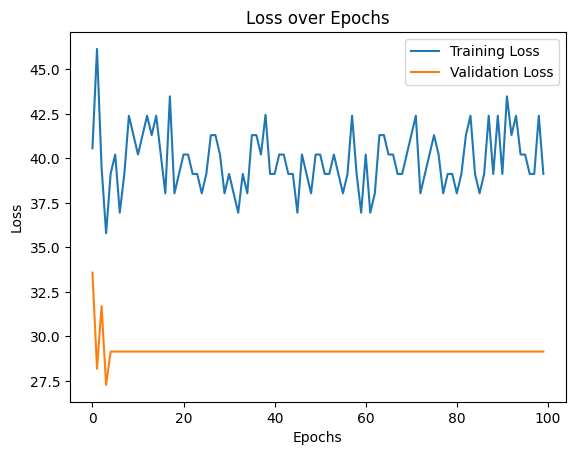

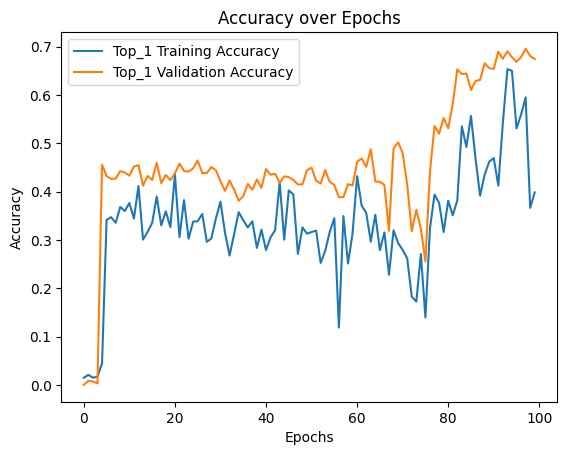

In [ ]:
metrics = best_history.history
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotta l'accuracy di training
plt.plot(metrics['factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Training Accuracy')
plt.plot(metrics['val_factorized_top_k/top_1_categorical_accuracy'], label='Top_1 Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
recommender.evaluate(test)

125/125 [==============================] - 14s 114ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.1361 - factorized_top_k/top_10_categorical_accuracy: 0.1361 - factorized_top_k/top_50_categorical_accuracy: 0.1376 - factorized_top_k/top_100_categorical_accuracy: 0.1401 - binary_accuracy: 0.8179 - loss: 116.1739 - regularization_loss: 0.0000e+00 - total_loss: 116.1739


[0.005786163732409477,
 0.136100634932518,
 0.136100634932518,
 0.13761006295681,
 0.14012578129768372,
 0.8178616166114807,
 20.72789764404297,
 0,
 20.72789764404297]


#Raccomandazioni per utente e per articolo

In [ ]:
class Index(tfrs.layers.factorized_top_k.BruteForce):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self._model = model

    def call(self, features):
        item_features = {
            "item_embedding": features["item_embedding"],
            "category_embedding": features["category_embedding"],
            "gender": features["gender"],
            "collection": features["collection"],
            "composition": features["composition"]
        }
        return self._model(item_features)

brute_force = Index(item_model)
brute_force.index_from_dataset(candidates_ds.map(lambda x: (x["item_id"],
                                 tf.concat([
                                     x["item_embedding"],
                                     x["category_embedding"],
                                     tf.expand_dims(tf.cast(x["gender"], tf.float32), -1),
                                    tf.expand_dims(tf.cast(x["collection"], tf.float32), -1),
            tf.expand_dims(tf.cast(x["composition"], tf.float32), -1)
                                 ], axis=1)))
)

In [ ]:
# Preparazione dei dati di input per il modello brute_force
def prepare_brute_force_input(item_features):
    # Concatena le features degli item
    item_inputs = tf.concat([
        item_features["item_embedding"],
        item_features["category_embedding"],
        tf.expand_dims(tf.cast(item_features["gender"], tf.float32), -1),
        tf.expand_dims(tf.cast(item_features["collection"], tf.float32), -1),
        tf.expand_dims(tf.cast(item_features["composition"], tf.float32), -1)
    ], axis=1)
    return item_inputs

# Prepara i dati degli item per brute_force
brute_force = Index(item_model)
candidates_ds_for_brute_force = candidates_ds.map(lambda x: (x["item_id"], prepare_brute_force_input(x)))

# Indicizza i dati degli item
brute_force.index_from_dataset(candidates_ds_for_brute_force)

# Ottieni le raccomandazioni per un utente specifico
user_id = tf.constant([unique_user_ids[0]])  # Sostituisci con un ID utente reale
user_features = {"user_id": user_id}
_, items = brute_force(user_features)


KeyError: "Exception encountered when calling layer 'index_4' (type Index).\n\nitem_embedding\n\nCall arguments received by layer 'index_4' (type Index):\n  • features={'user_id': 'tf.Tensor(shape=(1,), dtype=string)'}"

In [ ]:
user_id = tf.constant([91311])
user_model_input = {"user_id": user_id}
# Ottieni le raccomandazioni
_, items = brute_force(user_model_input)

KeyError: "Exception encountered when calling layer 'index_4' (type Index).\n\nitem_embedding\n\nCall arguments received by layer 'index_4' (type Index):\n  • features={'user_id': 'tf.Tensor(shape=(1,), dtype=int32)'}"

In [ ]:
brute_force = tfrs.layers.factorized_top_k.BruteForce(user_model)
brute_force.index(candidates_embeddings, identifiers=candidate_ids)

NameError: name 'candidates_embeddings' is not defined

In [ ]:
def user_recommendations(user_id, brute_force, k=5):
  user_id_tensor = tf.convert_to_tensor([[user_id]])
  _, item_ids = brute_force(user_id_tensor, k)
  return item_ids.numpy().flatten()

In [ ]:
uid = customers[customers['CustomerId']== 91311]['UserId']
print("User bought")
print(df_full[df_full['UserId']==uid.iloc[0]])
recommendation_ids = user_recommendations(uid.iloc[0], brute_force)
items[items['ItemId'].isin(recommendation_ids)]

User bought
                     Sku                   ItemName                  Category  \
5246  A20215810122793607  VINTAGE MERINOS CARDIGAN   ['Maglieria', 'Giacche']   
5259  A20215810122793012  VINTAGE MERINOS CARDIGAN   ['Maglieria', 'Giacche']   
8815  P20225516718190266         COTTON CREW NECK               ['Maglieria']   

      UnitPrice  ItemId     Collection  Availability  Color Gender  \
5246     343.64     969    Fall-Winter             0    607    Men   
5259     343.64     970    Fall-Winter             0     12    Men   
8815     125.00    1541  Spring-Summer             0    266    Men   

                                            Description  ... embedding_764  \
5246  cardigan in 100 extra fine merino wool featuri...  ...     -0.055354   
5259  cardigan in 100 extra fine merino wool featuri...  ...     -0.055354   
8815  pure cotton crew neck an essential every man s...  ...     -0.103326   

     embedding_765  embedding_766  embedding_767     Id  UserId  \
52

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,TextInfo
34,P20205713319003510,ORGANIC COTTON KNIT POLO,"['Polo, Camicie e T-shirt', 'Polo, Camicie e T...",130.00,34,Spring-Summer,0,510,Men,pin stitch polo shirt in organic cotton guaran...,cotton,organic cotton knit polo pin stitch polo shirt...
89,A20205510619669099,FULL ZIP WITH ALCANTARA PROFILES AND PATCHES,"['Cashmere', 'Maglieria', 'Giacche']",195.00,89,Fall-Winter,0,99,Men,cardigan in cashmere blend alcantara elbow pat...,cashmere,full zip with alcantara profiles and patches c...
143,A20205510619669039,FULL ZIP WITH ALCANTARA PROFILES AND PATCHES,"['Cashmere', 'Maglieria', 'Giacche']",159.84,143,Fall-Winter,0,39,Men,cardigan in cashmere blend alcantara elbow pat...,cashmere,full zip with alcantara profiles and patches c...
2904,P20235716669312598,ORGANIC COTTON DOUBLE-FACE GILET,"['Maglieria, Giacche']",370.00,2904,Spring-Summer,1,598,Men,reversible sleeveless jacket with hood doubles...,nylon,organic cotton double-face gilet reversible sl...
3039,P20235716669312005,ORGANIC COTTON DOUBLE-FACE GILET,"['Maglieria, Giacche']",265.00,3039,Spring-Summer,1,5,Men,reversible sleeveless jacket with hood doubles...,nylon,organic cotton double-face gilet reversible sl...


In [ ]:
total_hits = 0
total_predictions = 0

for batch in test:
  user_ids = batch['user_id']
  true_item_ids = batch['item_id'].numpy()
  _, predicted_item_batch_ids = brute_force(user_ids, k=1)
  predicted_item_batch_ids = predicted_item_batch_ids.numpy()
  for idx, uid in enumerate(user_ids):
    actual = true_item_ids[idx].flatten()
    predicted = predicted_item_batch_ids[idx].flatten()
    hits = np.intersect1d(predicted,actual).size
    total_hits += hits
    total_predictions += len(predicted)

# Calcola la precisione
precision_at_k = total_hits / total_predictions
print("Precision @ K:", precision_at_k)

ValueError: Exception encountered when calling layer 'brute_force' (type BruteForce).

The `index` method must be called first to create the retrieval index.

Call arguments received by layer 'brute_force' (type BruteForce):
  • queries=tf.Tensor(shape=(32, 1), dtype=int64)
  • k=1

In [ ]:
def similar_items(item_id, item_model, candidates_embeddings,candidates_ids,embedding_dim, k=5):
  input = df_embeddings.iloc[item_id].values[:embedding_dim].reshape(1, -1)
  item_embedding = item_model.predict(input)
  scores = tf.matmul(item_embedding, candidates_embeddings.T)
  top_k_indices = tf.math.top_k(scores, k=k+1).indices.numpy().flatten()
  top_k_indices = top_k_indices[top_k_indices != item_id]
  return [candidates_ids[i] for i in top_k_indices[:k]]

In [ ]:
items[items['ItemId']==0]

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,TextInfo
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,wool,micro rhombus stitch crew neck crew neck sweat...


In [ ]:
item_id = 0
similar_to = similar_items(item_id, item_model, candidates_embeddings, candidate_ids,embedding_dim, k=5)
items[items['ItemId'].isin(similar_to)]

1/1 [==============================] - 0s 18ms/step


,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,TextInfo
34,P20205713319003510,ORGANIC COTTON KNIT POLO,"['Polo, Camicie e T-shirt', 'Polo, Camicie e T...",130.00,34,Spring-Summer,0,510,Men,pin stitch polo shirt in organic cotton guaran...,cotton,organic cotton knit polo pin stitch polo shirt...
89,A20205510619669099,FULL ZIP WITH ALCANTARA PROFILES AND PATCHES,"['Cashmere', 'Maglieria', 'Giacche']",195.00,89,Fall-Winter,0,99,Men,cardigan in cashmere blend alcantara elbow pat...,cashmere,full zip with alcantara profiles and patches c...
143,A20205510619669039,FULL ZIP WITH ALCANTARA PROFILES AND PATCHES,"['Cashmere', 'Maglieria', 'Giacche']",159.84,143,Fall-Winter,0,39,Men,cardigan in cashmere blend alcantara elbow pat...,cashmere,full zip with alcantara profiles and patches c...
2904,P20235716669312598,ORGANIC COTTON DOUBLE-FACE GILET,"['Maglieria, Giacche']",370.00,2904,Spring-Summer,1,598,Men,reversible sleeveless jacket with hood doubles...,nylon,organic cotton double-face gilet reversible sl...
3039,P20235716669312005,ORGANIC COTTON DOUBLE-FACE GILET,"['Maglieria, Giacche']",265.00,3039,Spring-Summer,1,5,Men,reversible sleeveless jacket with hood doubles...,nylon,organic cotton double-face gilet reversible sl...
